<a href="https://colab.research.google.com/github/seenu-g/eva4-2/blob/master/week5/HumanPoseEstimation_ONNX_Quant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! git clone https://github.com/microsoft/human-pose-estimation.pytorch && cd human-pose-estimation.pytorch && git checkout 18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f

Cloning into 'human-pose-estimation.pytorch'...
remote: Enumerating objects: 188, done.
remote: Total 188 (delta 0), reused 0 (delta 0), pack-reused 188
Receiving objects: 100% (188/188), 68.78 KiB | 5.73 MiB/s, done.
Resolving deltas: 100% (86/86), done.
Note: checking out '18f1d0fa5b5db7fe08de640610f3fdbdbed8fb2f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 18f1d0f Update README.md


In [3]:
! pip install onnx onnxruntime

     |████████████████████████████████| 7.4MB 2.8MB/s 
     |████████████████████████████████| 4.4MB 49.1MB/s 


In [4]:
import sys
if "/content/human-pose-estimation.pytorch/lib/" not in sys.path:
    sys.path.insert(0, "/content/human-pose-estimation.pytorch/lib/")

In [5]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim
import torchvision.transforms as T

import cv2

import re
import os
import copy
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
import models
from core.config import config
from core.config import update_config
from core.config import update_dir
from core.config import get_model_name

In [8]:
! gdown https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc


Downloading...
From: https://drive.google.com/uc?id=1V2AaVpDSn-eS7jrFScHLJ-wvTFuQ0-Dc
To: /content/pose_resnet_50_256x256.pth.tar
136MB [00:02, 61.4MB/s]


In [9]:
CONFIG_FILE = '/content/human-pose-estimation.pytorch/experiments/mpii/resnet50/256x256_d256x3_adam_lr1e-3.yaml'
MODEL_PATH = '/content/pose_resnet_50_256x256.pth.tar'

In [10]:
update_config(CONFIG_FILE)
config.GPUS = '' # we are running on CPU

In [11]:
model = eval('models.'+config.MODEL.NAME+'.get_pose_net')(config, is_train=False)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
! wget https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg -O pose.jpg

--2020-08-26 18:33:14--  https://i.pinimg.com/474x/e7/6d/92/e76d92d3f4055099e955c35d955e0a34.jpg
Resolving i.pinimg.com (i.pinimg.com)... 23.54.200.222, 2600:1402:d800:2a0::1931, 2600:1402:d800:2b7::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|23.54.200.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12170 (12K) [image/jpeg]
Saving to: ‘pose.jpg’

pose.jpg            100%[===================>]  11.88K  --.-KB/s    in 0s      

2020-08-26 18:33:14 (128 MB/s) - ‘pose.jpg’ saved [12170/12170]



In [13]:
! wget https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png -O pose.png

--2020-08-26 18:33:24--  https://habrastorage.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving habrastorage.org (habrastorage.org)... 95.213.152.170
Connecting to habrastorage.org (habrastorage.org)|95.213.152.170|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png [following]
--2020-08-26 18:33:25--  https://hsto.org/webt/aa/xj/ls/aaxjls3wjnghu4ebwbjbquaz0hc.png
Resolving hsto.org (hsto.org)... 172.67.71.175, 104.26.12.161, 104.26.13.161, ...
Connecting to hsto.org (hsto.org)|172.67.71.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211894 (207K) [image/png]
Saving to: ‘pose.png’

pose.png            100%[===================>] 206.93K   663KB/s    in 0.3s    

2020-08-26 18:33:26 (663 KB/s) - ‘pose.png’ saved [211894/211894]



In [23]:
! wget https://github.com/seenu-g/school_of_ai/blob/master/chap13/COCO_annotation/IMG_2144.jpg?raw=true -O srini-pose.jpg

--2020-08-26 18:38:21--  https://github.com/seenu-g/school_of_ai/blob/master/chap13/COCO_annotation/IMG_2144.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/seenu-g/school_of_ai/raw/master/chap13/COCO_annotation/IMG_2144.jpg [following]
--2020-08-26 18:38:21--  https://github.com/seenu-g/school_of_ai/raw/master/chap13/COCO_annotation/IMG_2144.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/seenu-g/school_of_ai/master/chap13/COCO_annotation/IMG_2144.jpg [following]
--2020-08-26 18:38:21--  https://raw.githubusercontent.com/seenu-g/school_of_ai/master/chap13/COCO_annotation/IMG_2144.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuser

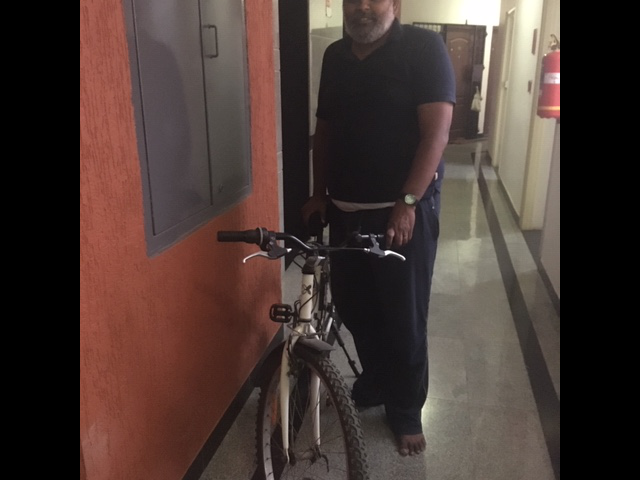

In [36]:
IMAGE_FILE = 'srini-pose.jpg'
image = Image.open(IMAGE_FILE)
image = image.convert('RGB')
image= image.rotate(270)
image

In [37]:
transform = T.Compose([
                       T.Resize((256, 256)),
                       T.ToTensor(),
                       T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                       ])

In [38]:
tr_img = transform(image)

In [40]:
tr_img = transform(image)
output = model(tr_img.unsqueeze(0))
output = output.squeeze(0)
_, OUT_HEIGHT, OUT_WIDTH = output.shape
output.shape

torch.Size([16, 64, 64])

In [41]:
get_detached = lambda x: copy.deepcopy(x.cpu().detach().numpy())


In [42]:
JOINTS = ['0 - r ankle', '1 - r knee', '2 - r hip', '3 - l hip', '4 - l knee', '5 - l ankle', '6 - pelvis', '7 - thorax', '8 - upper neck', '9 - head top', '10 - r wrist', '11 - r elbow', '12 - r shoulder', '13 - l shoulder', '14 - l elbow', '15 - l wrist']
JOINTS = [re.sub(r'[0-9]+|-', '', joint).strip().replace(' ', '-') for joint in JOINTS]

In [47]:
POSE_PAIRS = [
# UPPER BODY
              [9, 8],
              [8, 7],
              [7, 6],

# LOWER BODY
              [6, 2],
              [2, 1],
              [1, 0],

              [6, 3],
              [3, 4],
              [4, 5],

# ARMS
              [7, 12],
              [12, 11],
              [11, 10],

              [7, 13],
              [13, 14],
              [14, 15]
]

In [43]:
from operator import itemgetter
get_keypoints = lambda pose_layers: map(itemgetter(1, 3), [cv2.minMaxLoc(pose_layer) for pose_layer in pose_layers])

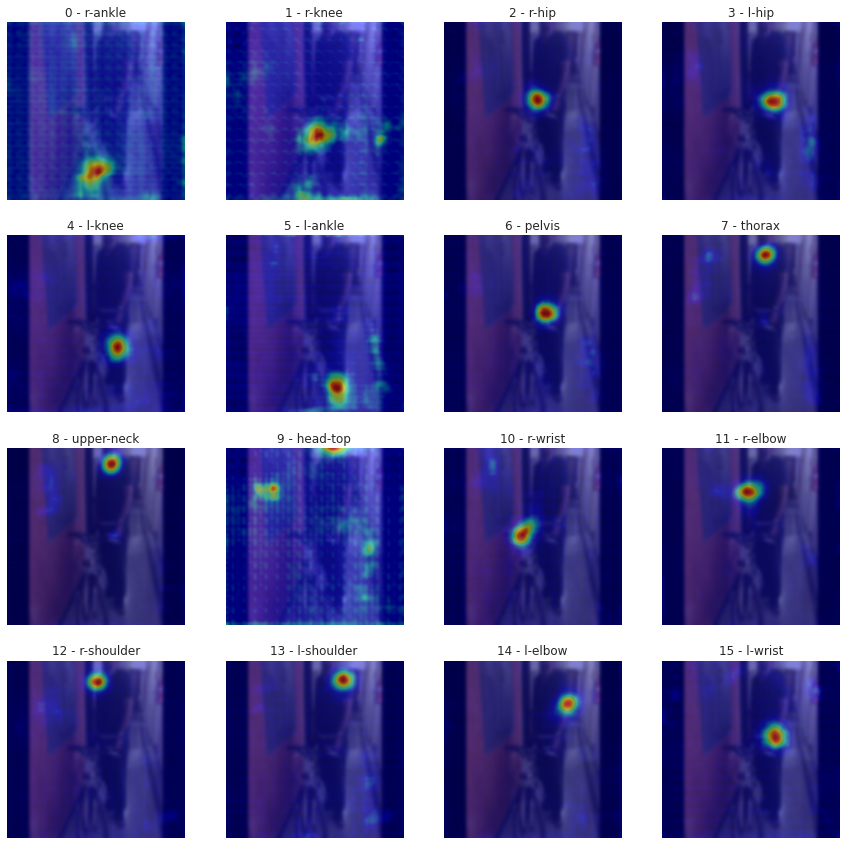

In [44]:
plt.figure(figsize=(15, 15))
for idx, pose_layer in enumerate(get_detached(output)):
    # print(pose_layer.shape)
    plt.subplot(4, 4, idx + 1)
    plt.title(f'{idx} - {JOINTS[idx]}')
    plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
    plt.imshow(pose_layer, alpha=0.5, cmap='jet', interpolation='bicubic')
    plt.axis('off')
plt.show()

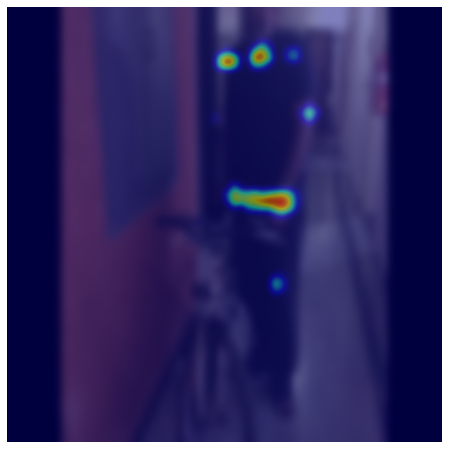

In [48]:
plt.figure(figsize=(8, 8))
plt.imshow(image.resize((OUT_WIDTH, OUT_HEIGHT)), cmap='gray', interpolation='bicubic')
pose_layers = get_detached(output)
pose_layers = np.clip(pose_layers, 0.7, 1.0)
layer_sum = np.sum(pose_layers, axis=0)
plt.imshow(layer_sum, alpha=0.5, cmap='jet', interpolation='bicubic')
plt.axis('off')
plt.show()

In [49]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = get_detached(x=output)
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

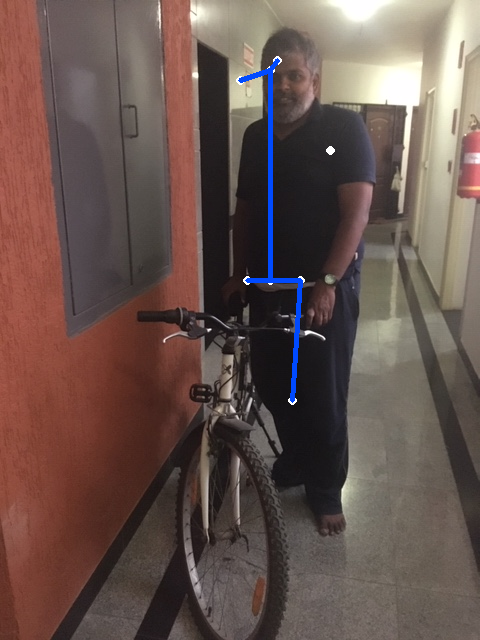

In [50]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))


In [60]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

def print_size_of_onnx_model(model):
    onnx.save(model, 'temp.onnx')
    print('Size (MB):', os.path.getsize("temp.onnx")/1e6)
    os.remove('temp.onnx')

In [61]:
print_size_of_model(model)

Size (MB): 136.326405


In [62]:
new_model = copy.deepcopy(model)

In [63]:
import io
import numpy as np
import torch.onnx

In [64]:
# Input to the model
torch_model = new_model
batch_size = 1
x = torch.randn(batch_size, 3, 256, 256, requires_grad=True)
torch_out = torch_model(x)

# Export the model
torch.onnx.export(torch_model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_pose_estimation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                                'output' : {0 : 'batch_size'}})

In [65]:
import onnx

onnx_model = onnx.load("simple_pose_estimation.onnx")
onnx.checker.check_model(onnx_model)

In [66]:
print_size_of_onnx_model(onnx_model)


Size (MB): 136.247923


In [68]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs = ort_outs[0][0]
len(ort_outs)


16

In [69]:
from onnxruntime.quantization import quantize
from onnxruntime.quantization import QuantizationMode

In [70]:
quantized_model = quantize(onnx_model, quantization_mode=QuantizationMode.IntegerOps, static=False)
onnx.save(quantized_model, 'simple_pose_estimation.quantized.onnx')
print_size_of_onnx_model(quantized_model)


Size (MB): 65.933789


In [71]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("simple_pose_estimation.quantized.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(tr_img.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)

np.array(ort_outs).shape
ort_outs = np.array(ort_outs[0][0])


In [ ]:
THRESHOLD = 0.8
OUT_SHAPE = (OUT_HEIGHT, OUT_WIDTH)
image_p = cv2.imread(IMAGE_FILE)
pose_layers = ort_outs
key_points = list(get_keypoints(pose_layers=pose_layers))
is_joint_plotted = [False for i in range(len(JOINTS))]
for pose_pair in POSE_PAIRS:
    from_j, to_j = pose_pair

    from_thr, (from_x_j, from_y_j) = key_points[from_j]
    to_thr, (to_x_j, to_y_j) = key_points[to_j]

    IMG_HEIGHT, IMG_WIDTH, _ = image_p.shape

    from_x_j, to_x_j = from_x_j * IMG_WIDTH / OUT_SHAPE[0], to_x_j * IMG_WIDTH / OUT_SHAPE[0]
    from_y_j, to_y_j = from_y_j * IMG_HEIGHT / OUT_SHAPE[1], to_y_j * IMG_HEIGHT / OUT_SHAPE[1]

    from_x_j, to_x_j = int(from_x_j), int(to_x_j)
    from_y_j, to_y_j = int(from_y_j), int(to_y_j)

    if from_thr > THRESHOLD and not is_joint_plotted[from_j]:
        # this is a joint
        cv2.ellipse(image_p, (from_x_j, from_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[from_j] = True

    if to_thr > THRESHOLD and not is_joint_plotted[to_j]:
        # this is a joint
        cv2.ellipse(image_p, (to_x_j, to_y_j), (4, 4), 0, 0, 360, (255, 255, 255), cv2.FILLED)
        is_joint_plotted[to_j] = True

    if from_thr > THRESHOLD and to_thr > THRESHOLD:
        # this is a joint connection, plot a line
        cv2.line(image_p, (from_x_j, from_y_j), (to_x_j, to_y_j), (255, 74, 0), 3)

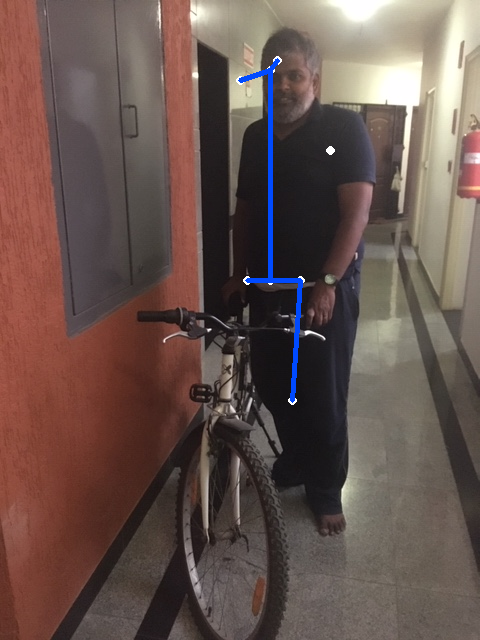

In [72]:
Image.fromarray(cv2.cvtColor(image_p, cv2.COLOR_RGB2BGR))
